In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
df1 = pd.read_csv('/datasets/games_data.csv')
df2 = pd.read_csv('/datasets/rating.csv')

In [2]:
df2.set_axis(['rating', 'decryption'], axis=1)
data = df1.merge(df2, on='rating', how='left')
data['total'] = data['online'] + data['offline']
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
data['sales_year'] = data['sales_year'].astype('int64')
data.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  """Entry point for launching an IPython kernel.


,platform,sales_year,genre,online,offline,critic_score,user_score,rating,game_id,decryption,total
0,PS3,2017,Action,702.0,909.0,97.0,8.2,M,20838,От 17 лет,1611.0
1,X360,2017,Action,966.0,514.0,97.0,8.1,M,48673,От 17 лет,1480.0
2,X360,2017,Shooter,904.0,424.0,88.0,3.4,M,17801,От 17 лет,1328.0
3,PS4,2015,Shooter,603.0,586.0,NaN,NaN,NaN,12200,NaN,1189.0
4,3DS,2017,Role-Playing,528.0,419.0,NaN,NaN,NaN,11432,NaN,947.0


Изучив внимательнее параметр dbt, можно сделать выводы, что игры с данным рейтингом имеют минимальное значение в общей выручке компании (до 253 сот. тыс.) а также их рейтинг критиков не поднимается выше 78 баллов. Других особых отличительных признаков по ним нет. Также есть и другие игры с низким рейтингом и кол-вом проданных экземпляров с наличием рейтинга. Заменю его на NaN для возможности дальнейшей обработки.
В расшифровке таблицы с рейтингом два значения 'K-A - Для всех (до 1998 года)' и 'AO - Только для взрослых' отсутствуют в общей таблице. Очевидно фирма ориентируется на современные игры для широкого спектра публики.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4026 entries, 0 to 4025
Data columns (total 11 columns):
platform        4026 non-null object
sales_year      4026 non-null int64
genre           4026 non-null object
online          4026 non-null float64
offline         4026 non-null float64
critic_score    1812 non-null float64
user_score      2032 non-null float64
rating          2315 non-null object
game_id         4026 non-null int64
decryption      2315 non-null object
total           4026 non-null float64
dtypes: float64(5), int64(2), object(4)
memory usage: 377.4+ KB


Шаг 3. Проведите исследовательский анализ данных
1. Постройте распределение количества игр по годам продажи и опишите полученный результат

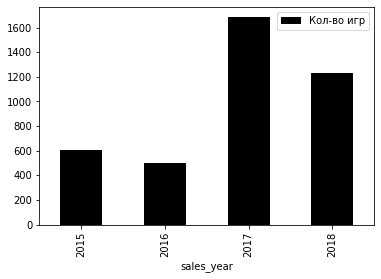

In [4]:
data_count_year = data.groupby('sales_year')['game_id'].count()
data_count_year.plot(kind='bar', legend=True, label='Кол-во игр', color='black')

В 2017 году в компании произошел какой-то невероятный скачек, они вышли из регрессии с показателем чуть ли не в 2,5 раза по отношению к 2016 году. Возможно это какая-то удачная рекламная кампания или выход на рынок давно ожидаемых игр. Такие резкие подъемы редко когда получается поддерживать долго и мы видим спад в 2018 году.

2. Постройте распределение по годам продажи для игр с отзывом и без отзыва; cравните полученные распределения и сделайте вывод

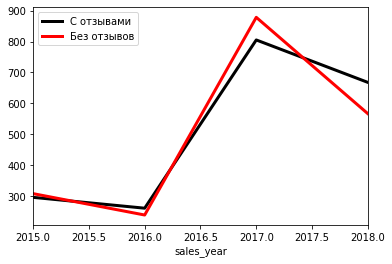

In [5]:
data_score_rev = data.query('user_score > 0').groupby('sales_year')['game_id'].count()
data_score_not_rev = data[data['user_score'].isna()].groupby('sales_year')['game_id'].count()
data_score_rev.plot(kind='line', legend=True, label='С отзывами', color='black', lw=3)
data_score_not_rev.plot(kind='line', legend=True, label='Без отзывов', color='red', lw=3)

Видимо людей не хватало в 2017 году писать отзывы на все новые игры. А также это может указывать, что вышли некие новые игры, которые, кстати, сделали продажи этого года.

3. Постройте график по суммам продаж каждого года; сделайте вывод

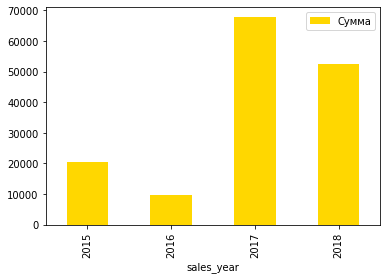

In [6]:
data_sales_year = data.groupby('sales_year')['total'].sum()
data_sales_year.plot(kind='bar', legend=True, label='Сумма', color='gold')

Неудивительно, что компания предприняла какие-то попытки выйти из падения в 2016 году. При учете, что разнообразие игр снизилось всего на 100 позиций, выручка по сравнению с 2015 годом упала в 2 раза.

4. Постройте ящик с усами по общим продажам, опишите полученный результат

count    4026.000000
mean       37.253353
std        99.359061
min         0.000000
25%         0.000000
50%         8.000000
75%        31.000000
max      1611.000000
Name: total, dtype: float64

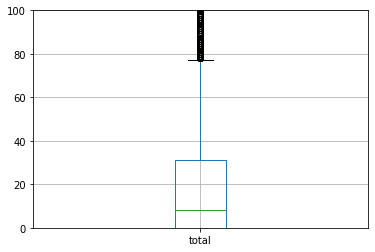

In [7]:
plt.ylim(0,100)
data.boxplot('total', figsize=(5,20))
data['total'].describe()

Нормальное распределение лежит примерно до 78 сот.тыс. Медиана ближе к нижнему квартилю, значит выбросов относительно немного. При этом среднее значение значительно выше медианы, значит в выборке много высоких значений. Стандартное отклонение велико, разброс величин неоднороден.

5. Узнайте, на какой платформе было продано больше всего игр

In [8]:
'Наибольшее количество игр ({} шт.) продано на платформе {}'.format(data.groupby('platform')['game_id'].count().max(), data.groupby('platform')['game_id'].count().idxmax())

'Наибольшее количество игр (708 шт.) продано на платформе PS3'

6. Определите, игр какого жанра больше всего

In [9]:
'Самый популярный жанр игр ({} разных игр) - это {}'.format(data.groupby('genre')['game_id'].count().max(), data.groupby('genre')['game_id'].count().idxmax())

'Самый популярный жанр игр (1270 разных игр) - это Action'

7. Найдите игры с наибольшей и наименьшей оценкой от пользователей

In [10]:
print(
    'ID игр с наибольшей оценкой от пользователей ({}) - это {}'
    .format(data['user_score'].max(), 
    data.loc[data['user_score'] == data['user_score'].max()]['game_id'].values)
)
print(
    'ID игры с наименьшей оценкой от пользователей ({}) - это {}'
    .format(data['user_score'].min(), 
    data.loc[data['user_score'] == data['user_score'].min()]['game_id'].values)
)

ID игр с наибольшей оценкой от пользователей (9.3) - это [12365 38270]
ID игры с наименьшей оценкой от пользователей (0.2) - это [23493]


8. Найдите игры с наибольшей и наименьшей оценкой от критиков

In [11]:
print(
    'ID игр с наибольшей оценкой от критиков ({}) - это {}'
    .format(data['critic_score'].max(), 
    data.loc[data['critic_score'] == data['critic_score'].max()]['game_id'].values)
)
print(
    'ID игры с наименьшей оценкой от критиков ({}) - это {}'
    .format(data['critic_score'].min(), 
    data.loc[data['critic_score'] == data['critic_score'].min()]['game_id'].values)
)

ID игр с наибольшей оценкой от критиков (97.0) - это [20838 48673 28618 39055]
ID игры с наименьшей оценкой от критиков (13.0) - это [28618]


9. Оцените корреляцию между оценками критиков и пользовательскими оценками.

In [12]:
data['critic_score'].corr(data['user_score'])

0.5348532967085243

Корреляция велика, рейтинг критиков и игроков зачастую совпадает.

Шаг 4. Составьте портрет пользователя для онлайн и офлайн продаж.
Для покупателей интернет-магазина и сети розничных магазинов определите:

1. топ-5 предпочтительных жанров

In [13]:
data.head()

,platform,sales_year,genre,online,offline,critic_score,user_score,rating,game_id,decryption,total
0,PS3,2017,Action,702.0,909.0,97.0,8.2,M,20838,От 17 лет,1611.0
1,X360,2017,Action,966.0,514.0,97.0,8.1,M,48673,От 17 лет,1480.0
2,X360,2017,Shooter,904.0,424.0,88.0,3.4,M,17801,От 17 лет,1328.0
3,PS4,2015,Shooter,603.0,586.0,NaN,NaN,NaN,12200,NaN,1189.0
4,3DS,2017,Role-Playing,528.0,419.0,NaN,NaN,NaN,11432,NaN,947.0


In [14]:
data_on_max = data.groupby('genre')['online'].sum().sort_values(ascending=False).head()
data_off_max = data.groupby('genre')['offline'].sum().sort_values(ascending=False).head()

print('Наиболее предпочтительные жанры для online-магазина: {}'.format(list(data_on_max.index)))
print('Наиболее предпочтительные жанры для offline-магазина: {}'.format(list(data_off_max.index)))

Наиболее предпочтительные жанры для online-магазина: ['Action', 'Shooter', 'Sports', 'Role-Playing', 'Misc']
Наиболее предпочтительные жанры для offline-магазина: ['Action', 'Shooter', 'Sports', 'Role-Playing', 'Racing']


2. в какие года пользователи были наиболее активны (больше всего покупали игры)

In [15]:
data_on_year = data.groupby('sales_year')['online'].sum()
data_off_year = data.groupby('sales_year')['offline'].sum()

print('Самый прибыльный год для online-магазина: {}'.format(data_on_year.idxmax()))
print('Самый прибыльный год для offline-магазина: {}'.format(data_off_year.idxmax()))

Самый прибыльный год для online-магазина: 2017
Самый прибыльный год для offline-магазина: 2017


3. топ-5 предпочтительных платформ

In [16]:
data_on_platform = data.groupby('platform')['online'].sum().sort_values(ascending=False).head()
data_off_platform = data.groupby('platform')['offline'].sum().sort_values(ascending=False).head()

print('Наиболее предпочтительные платформы для online-магазина: {}'.format(list(data_on_platform.index)))
print('Наиболее предпочтительные платформы для offline-магазина: {}'.format(list(data_off_platform.index)))

Наиболее предпочтительные платформы для online-магазина: ['X360', 'PS3', 'PS4', 'XOne', '3DS']
Наиболее предпочтительные платформы для offline-магазина: ['PS3', 'PS4', 'X360', '3DS', 'PC']


4. какой рейтинг ESRB встречается чаще всего (наиболее частотная категория)

In [17]:
data_on_rating = data.groupby(['rating', 'decryption'])['online'].sum()
data_off_rating = data.groupby(['rating', 'decryption'])['offline'].sum()

print('Наиболее популярный рейтинг для online-магазина: {}'.format(data_on_rating.idxmax()))
print('Наиболее популярный рейтинг для offline-магазина: {}'.format(data_off_rating.idxmax()))

Наиболее популярный рейтинг для online-магазина: ('M', 'От 17 лет')
Наиболее популярный рейтинг для offline-магазина: ('M', 'От 17 лет')


Шаг 5. Проверьте гипотезы:

1. средний пользовательский рейтинг платформ PS4 и PS3 одинаковый;

In [18]:
data_PS3 = data.query('platform == "PS3" & user_score !="NaN"')
data_PS4 = data.query('platform == "PS4" & user_score !="NaN"')

alpha = 0.05

results = st.ttest_ind(data_PS3['user_score'], data_PS4['user_score'], equal_var=False)
print('p-значение:', results.pvalue)

p-значение: 0.2543695482219482


Подтверждаем нулевую гипотезу. Пользовательский рейтинг платформ PS4 и PS3 одинаковый. Разница между рейтингами может возникнуть случайно с вероятностью почти 25%.

2. средний пользовательский рейтинг жанров Action и Sports различается.

In [19]:
data_Action = data.query('genre == "Action" & user_score !="NaN"')
data_Sports = data.query('genre == "Sports" & user_score !="NaN"')

alpha = 0.05

results1 = st.ttest_ind(data_Action['user_score'], data_Sports['user_score'], equal_var=False)
print('p-значение:', '{:.20f}'.format(results1.pvalue))

p-значение: 0.00000000000000000083


Отвергаем нулевую гипотезу о равенстве пользовательского рейтинга жанров Action и Sports. Разница между средними значениями пользовательского рейтинга в этих жанрах весома.

Общий вывод:
Для компании можно было бы посоветовать ориентироваться на игры жанров 'Action', 'Shooter', 'Sports', 'Role-Playing' и платформы 'X360', 'PS3', 'PS4', '3DS'. Также стоит ориентироваться на публику старше 10 лет. Для детей младшего возраста игры расходятся очень плохо.